## Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 
## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации

|reg_ts|uid|
|------|----|
|906166566|2|
|906344325|2|
|906686169|2|

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

|auth_ts|uid|
|-------|---|
|906166566|2|
|924422172|3|

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.


## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Формат данных:

|user_id|revenue|testgroup|
|------|------|------|
|1|0|b|
|2|0|a|
|3|0|a|

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import plotly.express as px
import numpy as np
from datetime import timedelta
from datetime import datetime as dt
import requests
from urllib.parse import urlencode
import scipy
from tqdm.auto import tqdm
from scipy.stats import norm

In [2]:
#выставим настройки графика
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

> В рамках задания была реализована функция подсчета **RETENTION** для конкретной когорты. В функцию подаются датасеты с данными о регистрации, о входе игроков в игру, дата интересующей когорты и дата дня в котором интересует параметр **RETENTION**. Для наглядности реализовано ветвление в котором тип отображения зависит от дня интересующего **RETENTION**. Так же предусмотрена защита от введения некорректных дат или дня.

In [3]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/daH9ebD0fa0J0A' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df_reg = pd.read_csv(download_url, sep=';')
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
#загрузим и посмотрим данные о входе в игру
public_key = 'https://disk.yandex.ru/d/opCobTjp9ysoXQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df_auth = pd.read_csv(download_url, sep=';')
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
def retention_n_day(df_reg,     # датафрейм с данными о регистраци
                    df_auth,    # датафрейм с данными о входе в игру
                    date_begin, # дата интересующей когорты
                    n           # день в который интересует retention
                   ):
    #создадим отдельную колонку с параметрами даты
    df_reg['date_reg'] = df_reg['reg_ts'].apply(lambda x: dt.fromtimestamp(x)).apply(lambda x: x.date())
    df_auth['date_auth'] = df_auth['auth_ts'].apply(lambda x: dt.fromtimestamp(x)).apply(lambda x: x.date())
    
    #провери корректность введенных данных
    if date_begin >= df_reg.date_reg.max():
        return print(f'Вы запрашиваете некорректную дату. В данных имеется информация с {df_reg.date_reg.min()} по {df_reg.date_reg.max()}') 
   
    
    # отберем данные по дате регистрации
    df_reg_period = df_reg[df_reg['date_reg'] == date_begin][['uid', 'date_reg']]
    
    #рассчитаем день retention которого нас интересует
    date_end = date_begin + timedelta(n)
    if date_end >= df_reg.date_reg.max():
        return print(f'Вы запрашиваете некорректную дату Retention{date_end}. В данных имеется информация с {df_reg.date_reg.min()} по {df_reg.date_reg.max()}') 
    
    # отберем данные по дате входа в игру конечной датой возьмем дату начала n дней
    df_auth_period = df_auth[df_auth['date_auth'] <= date_end]
    
    #соеденим получившиеся таблицы. джойнить будем к таблице с данными о входе в игру данные о 
    #регистрации по колонке идентификатора
    df_total = df_auth_period.merge(df_reg_period, on='uid', how='left')
    
    #удалим строки в которых отсутствуют данные о регистрации
    df_total = df_total.dropna()
    
    
    #групприуем данные по дате регистрации и дате входа в игру и считаем количество входов уникальных пользователей
    df_cohort = df_total.groupby(['date_reg', 'date_auth'], as_index=False).agg({'uid': 'nunique'})\
                        .rename(columns={'uid': 'total_aut'})
    
    #добавим дополнительный столбец, который показывает данные о глубине когорты
    df_cohort['day_dif'] = (df_cohort['date_auth'] - df_cohort['date_reg'])\
                            .apply(lambda x: x.total_seconds()/86400).astype(int) 
    #развернем датафрейм для наглядности
    df_cohort_pivot = df_cohort[['date_reg', 'day_dif', 'total_aut']]\
                        .pivot( index = 'date_reg', columns = 'day_dif', values = 'total_aut')
    #
    retention = df_cohort_pivot.div(df_cohort_pivot.iloc[:, 0], axis=0)
    
    if n <=7:
        ax = sns.heatmap(retention, annot = True,vmin = 0.0, vmax = 0.08, cmap="PuBu", fmt='0.1%')
        ax.set_title(f'Retention когорты {date_begin}', fontsize=28)
        ax.set_ylabel('Уровень Retention')
        ax.set_xlabel('День от даты регистрации') 
        return plt.show()
    elif n <=30:
        ax = sns.lineplot(x = retention.columns, y = retention.iloc[0])
        ax.set_title(f'Retention когорты {date_begin}', fontsize=28)
        ax.set_ylabel('Уровень Retention')
        ax.set_xlabel('День от даты регистрации') 
        return plt.show()
    else:
        return print(f'Retention {n} дня равен = {round(retention.iloc[0][n], 3) * 100} %')
    

In [6]:
#задаем дату наблюдения
date = dt(2018,10,31).date()

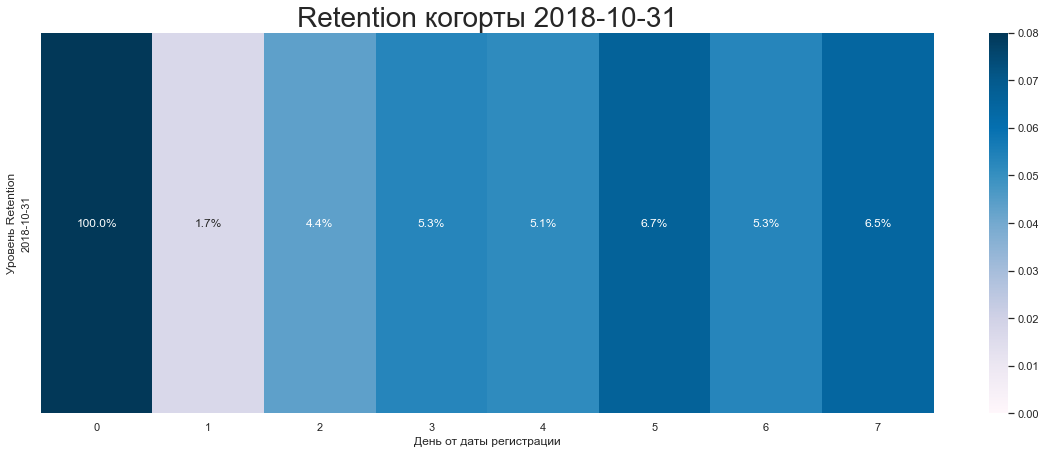

In [7]:
#применяем функцию
retention_n_day(df_reg, df_auth, date, 7)

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Формат данных:

|user_id|revenue|testgroup|
|------|------|------|
|1|0|b|
|2|0|a|
|3|0|a|

In [8]:
#обозначим функцию BootStrap
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

## 2.0 Загрузка данных и предобработка

In [9]:
# используем api 
public_key = 'https://disk.yandex.ru/d/FWXlZuqSdNZOIg' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df_game = pd.read_csv(download_url, sep=';')
df_game.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [10]:
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [11]:
#проверим количество повторяющихся клиентов
df_game.user_id.duplicated().sum()

0

In [12]:
df_game.query('testgroup == "a"').describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [13]:
df_game.query('testgroup == "b"').describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


---
в группе "a" мы наблюдаем очень высокое значение revenue по отношению к группе "а" необходимо оценить количество таких наблюдений

---

<AxesSubplot:xlabel='revenue', ylabel='Count'>

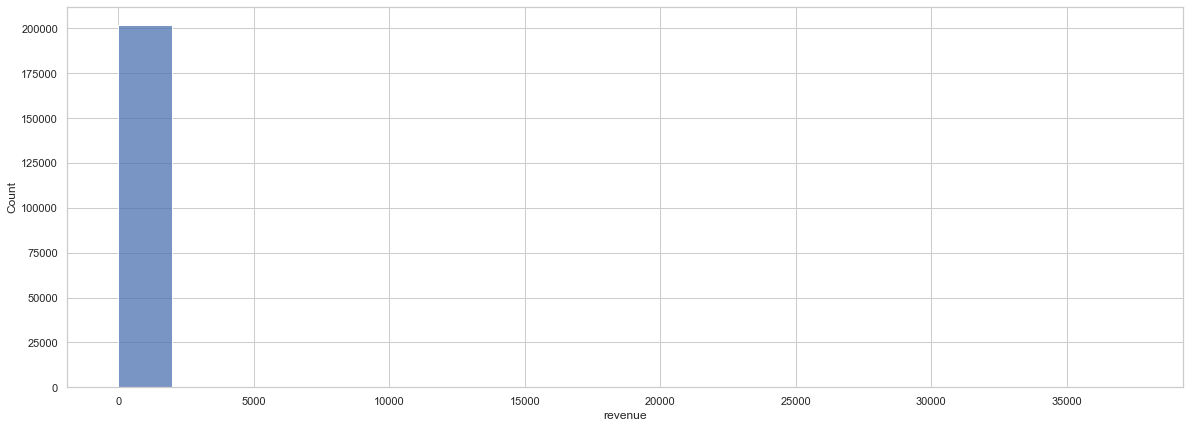

In [14]:
sns.histplot(df_game.query('testgroup == "a"')['revenue'])

---
Из графика видно, что абсолютное большинство наблюдений не превышает значение **revenue** > 5000. Необходимо оценить какое количество наблюдений вышло за эту границу

---

In [15]:
df_game.query('testgroup == "a" and revenue > 5000').user_id.nunique()

123

---
Таких значений больше чем одно, а из платящей части клиентов в группе "а" 1928, 123 составляет 6,3% от выборки. Следовательно эти наблюдения не являются выбросами и мы обязаны их учитывать в предстоящем тесте

---

In [16]:
#определим количество уникальных элементов
df_game.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

> мы видим что, все элементы в данном аб тесте уникальны, это значит мы не можем определить изменение метрик **повторные покупки** или **средний чек**. Так же нет данных об изменении **revenue** в динамике. Вместе с тем нам доступна оценка **конверсии**, **ARPU** и **ARPPU**. Для оценки данных метрик проанализируем значимость результатов AB-теста. Для начала используем его для оценки **ARPU**.

## 2.1 Оценка ARPU

<AxesSubplot:xlabel='revenue', ylabel='Count'>

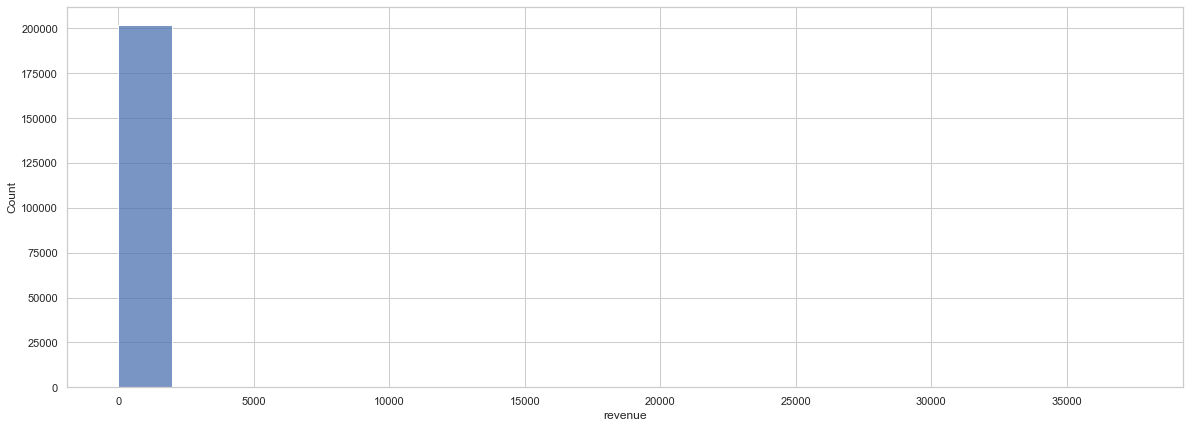

In [17]:
#для начала посмотрим на распределение в группе A и группе B
sns.histplot(df_game.query('testgroup == "a"')['revenue'])

<AxesSubplot:xlabel='revenue', ylabel='Count'>

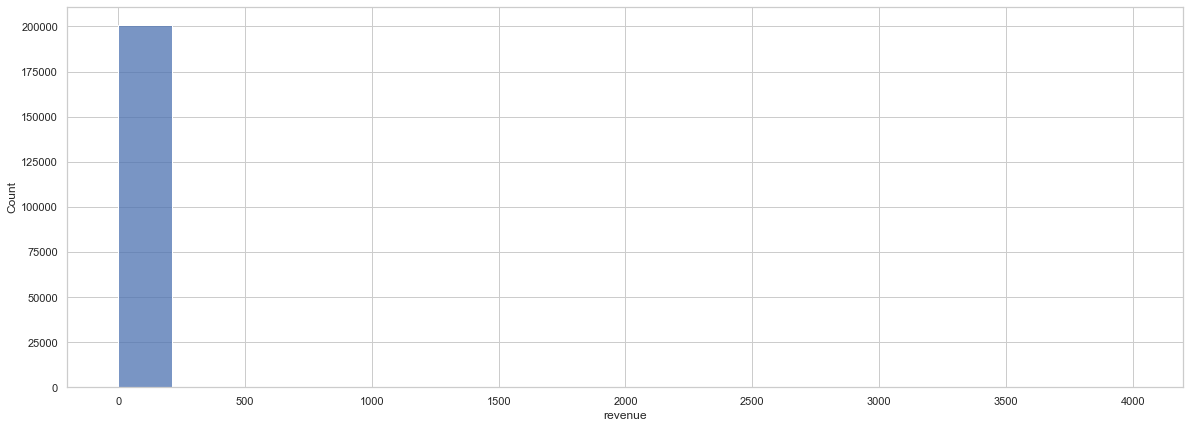

In [18]:
sns.histplot(df_game.query('testgroup == "b"')['revenue'])

---
По внешнему виду распределения не похожи на нормальные, для убедительности проведем проверку Использую тест Шапиро-Уилка

---

In [19]:
scipy.stats.shapiro(df_game.query('testgroup == "a"')['revenue'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [20]:
scipy.stats.shapiro(df_game.query('testgroup == "b"')['revenue'])

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

---
в тесте Шапиро-Уилка уровень значимости p-value получается меньше 0.05, что позволяет нам отвергнуть нулевую гипотезу о нормалньости распределения данных в обоих выборках.

Наша выборка имеет большое количество наблюдений, однако распределение в ней не является нормальным. Учитывая это, оценить статзначимость различия в результатах теста нам поможет тест Манна-Уитни

Сформулируем гипотезы:\
**0 Гипотеза**: Средние значения двух выборок равны\
**1 Гипотеза**: Средние значения дву выборок имеют статзначимые различия

---

In [21]:
scipy.stats.mannwhitneyu(df_game.query('testgroup == "a"')['revenue'], df_game.query('testgroup == "b"')['revenue'])

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

---
Тест Манна-Уитни не показал статзначимых различий между двумя выборками. Дополнительно проведем bootsprat, чтобы проверить наше предположение

---

  0%|          | 0/1000 [00:00<?, ?it/s]

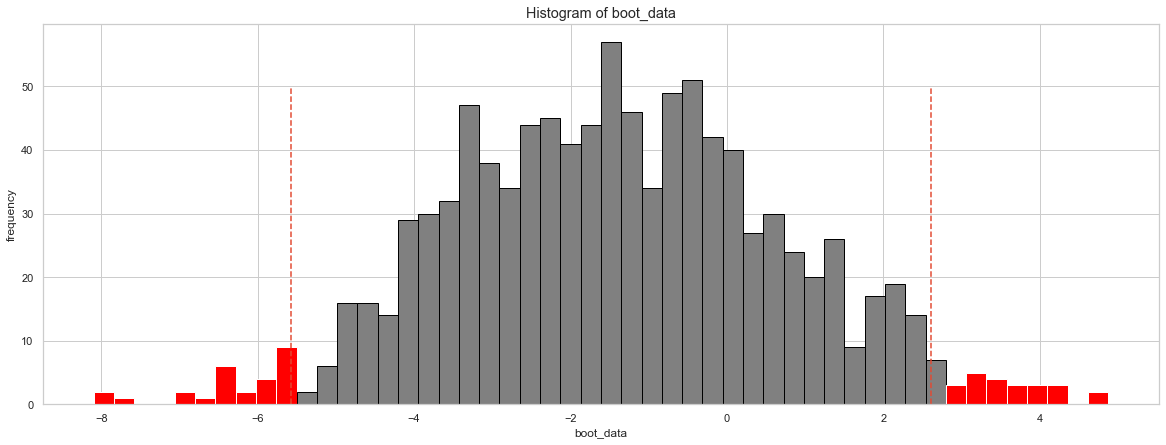

{'boot_data': [-0.3985888383645957,
  -4.020519240189408,
  -0.4970188468256289,
  -2.3709098825846233,
  0.12339747554464608,
  0.2555825494920896,
  -1.1274597606171106,
  -2.256403912856314,
  -0.3796331573504581,
  -3.576028064897603,
  -1.5808226498369642,
  1.4029826375659944,
  0.5731829809552558,
  1.0347496078732128,
  1.1225414763759076,
  2.208824213396138,
  -2.990405882149201,
  -1.5004725313330312,
  3.066896582435689,
  2.581263019351521,
  -2.147137845553999,
  -3.0306032072754974,
  -4.132259293528545,
  -5.057554811160646,
  -1.5112492145094336,
  -0.6481249659826922,
  -1.5813421869046955,
  -2.276977580738535,
  -1.5440047896369649,
  -2.068440349722664,
  -3.060286091745297,
  -0.25131244959253607,
  2.2512679178438724,
  -0.31747673216132455,
  -3.213331815955229,
  -1.806489760171793,
  -0.5657560748727128,
  -4.87218893336566,
  2.5531288501407694,
  0.6033161308837585,
  -2.534306764372623,
  -7.8393739825732425,
  -1.9851214479745494,
  -0.2664433481937394,
  

In [22]:
get_bootstrap(df_game.query('testgroup == "a"')['revenue'], df_game.query('testgroup == "b"')['revenue'])

> Bootstrap так же показал статзначимых различий между двумя выборками. Следовательно можно сделать вывод что изменение метрики ARPU не является статзначимым поэтому сложно сказать какой из набор предложений был лучшим. Однакомы метриКа ARPU рассчитывается по формуле $ARPU = Конверсия * ARPPU$- попробуем оценить статзначимость в изменение этих двух показателей для оценки предложений

## 2.2 Оценка ARPPU

In [23]:
#для оценки ARPPU отберем данные в которых пользователи совершили покупки
df_ARPPU = df_game.query('revenue > 0')

In [24]:
#оценим получившиеся данные для каждой из групп
df_ARPPU.query('testgroup == "a"').describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [25]:
df_ARPPU.query('testgroup == "b"').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


---
Используя тест Шапиро-Уилка проверим получившиеся два распределения на нормальность

---

In [26]:
scipy.stats.shapiro(df_ARPPU.query('testgroup == "a"')['revenue'])

ShapiroResult(statistic=0.26679253578186035, pvalue=0.0)

In [27]:
scipy.stats.shapiro(df_ARPPU.query('testgroup == "b"')['revenue'])

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

---
Статзначимость в обоих случаях значительно меньше p-value=0.05, и это позволяет отвергнуть нулевую гипотезу о нромальности получившихся распределений. Следовательно для оценки статзначимых различи применим непараметрический тест Манна-Уитни
Сформулируем гипотезы:\
**0 Гипотеза**: Средние значения двух выборок равны\
**1 Гипотеза**: Средние значения дву выборок имеют статзначимые различия

---

In [28]:
scipy.stats.mannwhitneyu(df_ARPPU.query('testgroup == "a"')['revenue'], df_ARPPU.query('testgroup == "b"')['revenue'])

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

---
В этот раз тест Манна-Уитни показал статзначимость бежду двумя выборками. Для убедительности проведем bootstrap

---

  0%|          | 0/1000 [00:00<?, ?it/s]

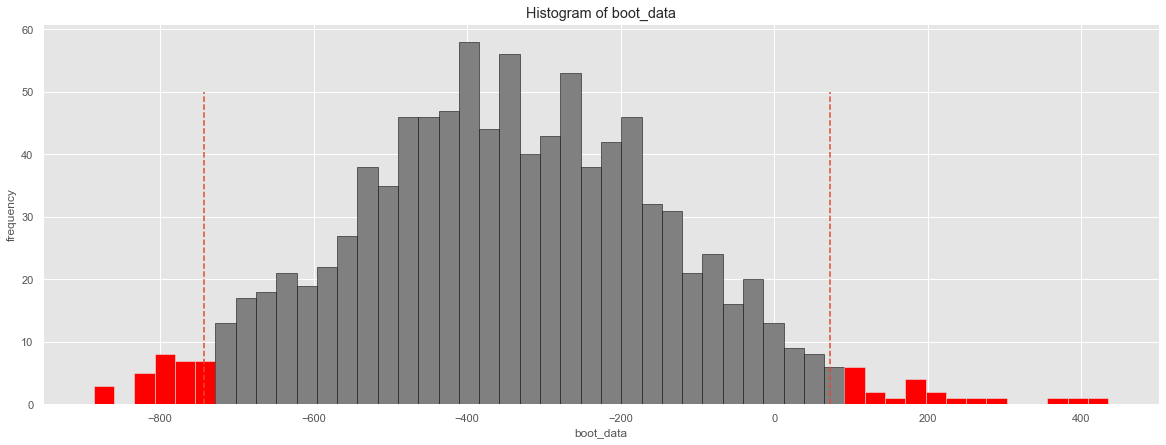

{'boot_data': [-145.9538381742741,
  -193.6364107883819,
  -230.86307053941937,
  -158.2162863070539,
  -114.27282157676336,
  -58.269190871369574,
  83.32002074688762,
  -682.7328838174276,
  33.71369294605802,
  -816.5912863070539,
  -360.8796680497926,
  28.682572614107812,
  -150.52541493775925,
  -246.33091286307035,
  -279.4398340248963,
  -683.1504149377593,
  -645.6239626556016,
  -356.84699170124486,
  -506.35217842323664,
  -682.9009336099584,
  -391.42219917012426,
  -402.0269709543568,
  -90.70383817427364,
  -252.64885892116172,
  -673.3127593360996,
  -641.2157676348547,
  -438.7458506224066,
  -125.62551867219918,
  -500.71524896265555,
  -719.0850622406638,
  -446.2261410788383,
  114.09699170124486,
  -490.96317427385884,
  -517.7536307053942,
  -630.9917012448132,
  -514.5860995850626,
  -38.65145228215761,
  -415.1198132780087,
  381.80653526970946,
  -252.92531120331932,
  -277.4621369294605,
  -353.28941908713705,
  -400.7204356846473,
  -699.9528008298757,
  -294.

In [29]:
get_bootstrap(df_ARPPU.query('testgroup == "a"')['revenue'], df_ARPPU.query('testgroup == "b"')['revenue'])

---
Однако при более подробном рассмотрении мы увидели, что две выборки сильно не различаются между собой.
Поэтому попробуем оценить конверсии для анализируемых групп

---

## 2.3 Оценка конверсии двух выборок

In [30]:
#создадим колонку в которой отобразим преобразовался ли наш пользователь в клиента или нет
df_game['converted'] = df_game['revenue'].apply(lambda x: 1 if x > 0 else 0)

In [31]:
df_game.head()

,user_id,revenue,testgroup,converted
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [32]:
# теперь зададиm матрицу значений для группы "а" и групп "b"
a_converted = df_game.query('testgroup == "a"').converted.sum()
a_no_converted = df_game.query('testgroup == "a"').converted.count() - a_converted

b_converted = df_game.query('testgroup == "b"').converted.sum()
b_no_converted = df_game.query('testgroup == "b"').converted.count() - b_converted

#создаем массив
T = np.array([[a_converted, a_no_converted], [b_converted, b_no_converted]])

In [33]:
b_no_converted

200862

In [34]:
print(scipy.stats.chi2_contingency(T,correction=False)[1])

0.0350285246428554


---
мы получили значения p-value < 5% поэтому можем говорить о статзначимости двух выборок. Теперь определим в какой группе конверсия была выше

---

In [35]:
#конверсия группы "а"
round(a_converted/df_game.query('testgroup == "a"').converted.count(), 5)

0.00954

In [36]:
#конверсия группы "b"
round(b_converted/df_game.query('testgroup == "b"').converted.count(), 5)

0.00891

> **ВЫВОД** Основываясь на проведенном анализе мы можем сказать, что набор акционных предложений группы  "a" является более выгодным. Потому что различия в конверсии двух предложений показали статзначимый результат, а именно **конверсия** в группе "a" составила 0,95% против **конверсии** группы "b" 0,89%. В то время как изменение метрик **ARPU** и **ARPPU** показали не статзначимый результат.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## 3.1 Оценка результата прошедшего события

В данном случае чтобы сравнить результаты события последнего месяца можено оценить следующие метрики:
    
   1. **MAU** - с ее помощью можно сравнить количество уникальных пользователей в месяц с предыдущими месяцами.
   
   2. **Завершенность** - позволит оценить количество пользователей прошедших  событие до конца
   
   3. **Скорость прохождения** - позволит выявить сколько в среднем потребовалось времени на прохождения события и оценить сложность события(не было ли очередное событие слишком сложным или слишком легким)
   
   4. **Retention n-го дня** - имея информацию о возвращаемости клиентов в игру с момента начала события мы сможем понять насколько игроки вовлечены в игру
   
   5. **Количество пройденных уровней** - позволит определить уровни, сложность которых требует корректировки
   
   6. **Оценка удовлетворенности клиентов (customer satisfaction score, CSAT)** - с помощью голосования по окончанию события можно оценить удовлетворенность клиентов от 1 - 5.
   
   7. **Количество докупаемых попыток** - даст понимание насколько прибыльным оказалось событие для организации
    
   9. **ARPU** - Увеличение/уменьшение это характеристик дополнительно поможет отслеживать увлеичилось или уменьшилось количество покупок в игру

## 3.2 Оценка результата в случае усложнение механики события

В случае когда механика игры будет усложнена помимо метрик озвученных выше, стоит так же оценить:

 1. **Количество уровней на которое откатывался каждый пользователь** - позволит оценить как много времени заняло прохождение уровней
 2. **churn rate** - позволить проследить сколько пользователей покинуло событие
 3. **Средняя продолжительность сессии (average session length, ASL)** - так же позволит оценить сосредоточенность и вовлеченность в игру, а так же отследить больше ли времени пользователи стали проводить в игре
 4. **Оценка в GooglePlay/AppStore** - контроль этой метрики позволит оценить насколько удовлетворены пользователи изменением механики игры.
 5. **Активность чатов сообщества игра** - Позволит в более гибкой форме понять реакцию игроков на событие игры